In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [2]:
# CONFIGURACIÓN PARA RADAR DE EQUIPOS
TABLE_TYPE = 'domestic'
LEAGUES = ['ESP-La Liga']
SEASON = '2526'
TARGET_TEAM = 'Atlético Madrid'

# Configuración de colores del Atlético Madrid
ATM_COLORS = ['#FF6B6B', '#FFFFFF']  # Rojo y blanco

SAVE_PATH_BASE = "../images/mfichajes/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Consulta para obtener datos de equipos
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_team_id,
    team_name,
    league,
    season,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.teams_{TABLE_TYPE} t
WHERE t.league IN ('{league_list_str}')
AND t.season = '{SEASON}'
ORDER BY t.team_name
"""

df_teams_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Equipos extraídos: {df_teams_raw.shape[0]} registros, {df_teams_raw.shape[1]} columnas")
df_teams_raw.head()

2025-09-04 14:16:13,961 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-09-04 14:16:14,375 - database.connection - INFO - Database connection successful


Equipos extraídos: 20 registros, 6 columnas


,unique_team_id,team_name,league,season,fbref_metrics,understat_metrics
0,62af897ad74e3d09,Alavés,ESP-La Liga,2526,"{'CS': '0', 'FK': '1', 'OG': '0', 'Age': '27.7...",{}
1,7265c69f86192d74,Athletic Club,ESP-La Liga,2526,"{'CS': '1', 'FK': '0', 'OG': '0', 'Age': '27.5...",{}
2,99e28b1f4265d292,Atlético Madrid,ESP-La Liga,2526,"{'CS': '0', 'FK': '1', 'OG': '0', 'Age': '27.0...",{}
3,fc69e31661e07d56,Barcelona,ESP-La Liga,2526,"{'CS': '1', 'FK': '2', 'OG': '0', 'Age': '24.4...",{}
4,b859be19a8f9f674,Betis,ESP-La Liga,2526,"{'CS': '1', 'FK': '2', 'OG': '1', 'Age': '28.1...",{}


In [4]:
def extract_team_metrics(df, col_name):
    """Extrae métricas numéricas de columnas JSON para equipos"""
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        # Para equipos, requerimos al menos 3 valores válidos
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 3:
            result[key] = values
    
    return result

def _convert_to_float(value):
    """Convierte valores a float de manera segura"""
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

# Extraer métricas de equipos
team_fbref_metrics = extract_team_metrics(df_teams_raw, 'fbref_metrics')
team_understat_metrics = extract_team_metrics(df_teams_raw, 'understat_metrics')

print(f"FBref equipos: {team_fbref_metrics.shape[1]} métricas")
print(f"Understat equipos: {team_understat_metrics.shape[1]} métricas")

FBref equipos: 186 métricas
Understat equipos: 0 métricas


In [5]:
# Combinar todas las métricas de equipos
all_team_metrics = pd.concat([team_fbref_metrics, team_understat_metrics], axis=1)

# Calcular percentiles para equipos (comparación entre equipos de La Liga)
team_percentiles = all_team_metrics.rank(pct=True) * 98 + 1
team_percentiles = team_percentiles.round(0).astype('Int64')
team_percentiles.columns = [f'{col}_pct' for col in team_percentiles.columns]

# DataFrame final de equipos
base_team_cols = ['unique_team_id', 'team_name', 'league', 'season']

df_teams_final = pd.concat([
    df_teams_raw[base_team_cols],
    all_team_metrics,
    team_percentiles
], axis=1)

print(f"DataFrame final de equipos: {df_teams_final.shape[0]} filas, {df_teams_final.shape[1]} columnas")
print(f"\nEquipos disponibles:")
for team in sorted(df_teams_final['team_name'].unique()):
    print(f"  - {team}")

DataFrame final de equipos: 20 filas, 376 columnas

Equipos disponibles:
  - Alavés
  - Athletic Club
  - Atlético Madrid
  - Barcelona
  - Betis
  - Celta Vigo
  - Elche
  - Espanyol
  - Getafe
  - Girona
  - Levante
  - Mallorca
  - Osasuna
  - Oviedo
  - Rayo Vallecano
  - Real Madrid
  - Real Sociedad
  - Sevilla
  - Valencia
  - Villarreal


In [6]:
# Explorar métricas disponibles para equipos
print("MÉTRICAS DISPONIBLES PARA EQUIPOS:")
print("=" * 50)

team_metrics_sorted = sorted(list(all_team_metrics.columns))
for i, metric in enumerate(team_metrics_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal métricas: {len(team_metrics_sorted)}")

MÉTRICAS DISPONIBLES PARA EQUIPOS:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Age
 8. Blocks_Blocks
 9. Blocks_Pass
10. Blocks_Sh
11. CS
12. CS%
13. Carries_1/3
14. Carries_CPA
15. Carries_Carries
16. Carries_Dis
17. Carries_Mis
18. Carries_PrgC
19. Carries_PrgDist
20. Carries_TotDist
21. Challenges_Att
22. Challenges_Lost
23. Challenges_Tkl
24. Challenges_Tkl%
25. Corner Kicks_In
26. Corner Kicks_Out
27. Corner Kicks_Str
28. Crosses_Opp
29. Crosses_Stp
30. Crosses_Stp%
31. Crs
32. CrsPA
33. FK
34. Fld
35. Fls
36. G+A-PK
37. G-xG
38. GA90
39. GCA Types_Def
40. GCA Types_Fld
41. GCA Types_PassDead
42. GCA Types_PassLive
43. GCA Types_Sh
44. GCA Types_TO
45. GCA_GCA
46. GCA_GCA90
47. Goal Kicks_Att
48. Goal Kicks_AvgLen
49. Goal Kicks_Launch%
50. Goals_CK
51. Goals_FK
52. Goals_GA
53. Goals_OG
54. Goals_PKA
55. Launched_Att
56. Launched_Cmp
57. Launched_Cmp%
58. Min%
59. OG
60. Off
61. Outcomes_Blocks
62. Outcomes_Cmp
63. Outcomes_Off

In [ ]:
# SELECCIÓN DE MÉTRICAS PARA EL RADAR DEL EQUIPO (POR 90 MINUTOS)
# Métricas optimizadas para reflejar el mal momento del Atlético Madrid

# Métricas por 90 minutos más representativas
team_radar_metrics = [
    'GA90',                     # Goles en contra por 90 min (clave defensiva)
    'SoT/90',                   # Tiros a puerta por 90 min (eficacia ofensiva)  
    'shots_per_90',             # Tiros totales por 90 min (volumen ofensivo)
    'Team Success (xG)_xG+/-90', # Diferencia xG por 90 min (balance juego)
    'Poss',                     # Posesión del balón (control del juego)
    'pass_completion_pct',      # % Pases completados (precisión)
    'Progression_PrgP',         # Pases progresivos (progresión ofensiva)
    'Tkl+Int',                  # Entradas + Intercepciones (intensidad defensiva)
    'Recov',                    # Recuperaciones (presión y trabajo)
    'Fls'                       # Faltas cometidas (disciplina/frustración)
]

team_radar_titles = [
    'Goals Against/90',         # Goles en contra por 90'
    'Shots on Target/90',       # Tiros a puerta por 90'
    'Total Shots/90',           # Tiros totales por 90'
    'xG Difference/90',         # Diferencia xG por 90'
    'Possession %',             # Posesión del balón
    'Pass Accuracy %',          # Precisión de pases
    'Progressive Passes',       # Pases progresivos
    'Tackles + Interceptions',  # Entradas + Intercepciones
    'Recoveries',               # Recuperaciones
    'Fouls Committed'           # Faltas cometidas
]

# Métricas que deben invertirse (menor es mejor para el equipo)
invert_metrics = ['GA90', 'Fls']  # Menos goles en contra, menos faltas

# Verificar que todas las métricas están disponibles
available_metrics = [m for m in team_radar_metrics if m in all_team_metrics.columns]
missing_metrics = [m for m in team_radar_metrics if m not in all_team_metrics.columns]

print(f"Métricas disponibles: {len(available_metrics)}/{len(team_radar_metrics)}")
if missing_metrics:
    print(f"Métricas no disponibles: {missing_metrics}")

print(f"\nMétricas seleccionadas para el radar (por 90 minutos):")
for i, (metric, title) in enumerate(zip(team_radar_metrics, team_radar_titles), 1):
    status = "✓" if metric in available_metrics else "✗"
    invert = " (invertida)" if metric in invert_metrics else ""
    print(f"{i:2d}. {status} {title}{invert}")

In [8]:
# Encontrar el Atlético Madrid
atletico_data = df_teams_final[df_teams_final['team_name'] == TARGET_TEAM]

if len(atletico_data) > 0:
    atletico_id = atletico_data.iloc[0]['unique_team_id']
    print(f"✓ {TARGET_TEAM} encontrado")
    print(f"  ID: {atletico_id}")
    
    # Mostrar los valores de las métricas seleccionadas
    print(f"\nMétricas del {TARGET_TEAM}:")
    print("=" * 40)
    
    for metric, title in zip(team_radar_metrics, team_radar_titles):
        if metric in available_metrics:
            raw_value = atletico_data.iloc[0][metric]
            percentile = atletico_data.iloc[0][f'{metric}_pct']
            print(f"{title:20s}: {raw_value:8.2f} (percentil {percentile})")
        else:
            print(f"{title:20s}: No disponible")
            
else:
    print(f"✗ {TARGET_TEAM} no encontrado")
    print("Equipos disponibles:")
    for team in sorted(df_teams_final['team_name'].unique()):
        print(f"  - {team}")

✓ Atlético Madrid encontrado
  ID: 99e28b1f4265d292

Métricas del Atlético Madrid:
Goals Against/90    :     1.33 (percentil 70)
Shots on Target/90  :     5.33 (percentil 82)
Post-Shot xG Against:      nan (percentil <NA>)
xG Difference/90    :     0.37 (percentil 70)
Possession %        :    59.30 (percentil 89)
Pass Accuracy %     :    83.70 (percentil 70)
Progressive Passes  :   179.00 (percentil 89)
Tackles + Interceptions:    71.00 (percentil 50)
Recoveries          :   149.00 (percentil 89)
Fouls Committed     :    42.00 (percentil 67)


Generando radar del Atlético Madrid con 10 métricas...
✓ Radar del equipo completado: Atletico_Madrid_team_combined.png


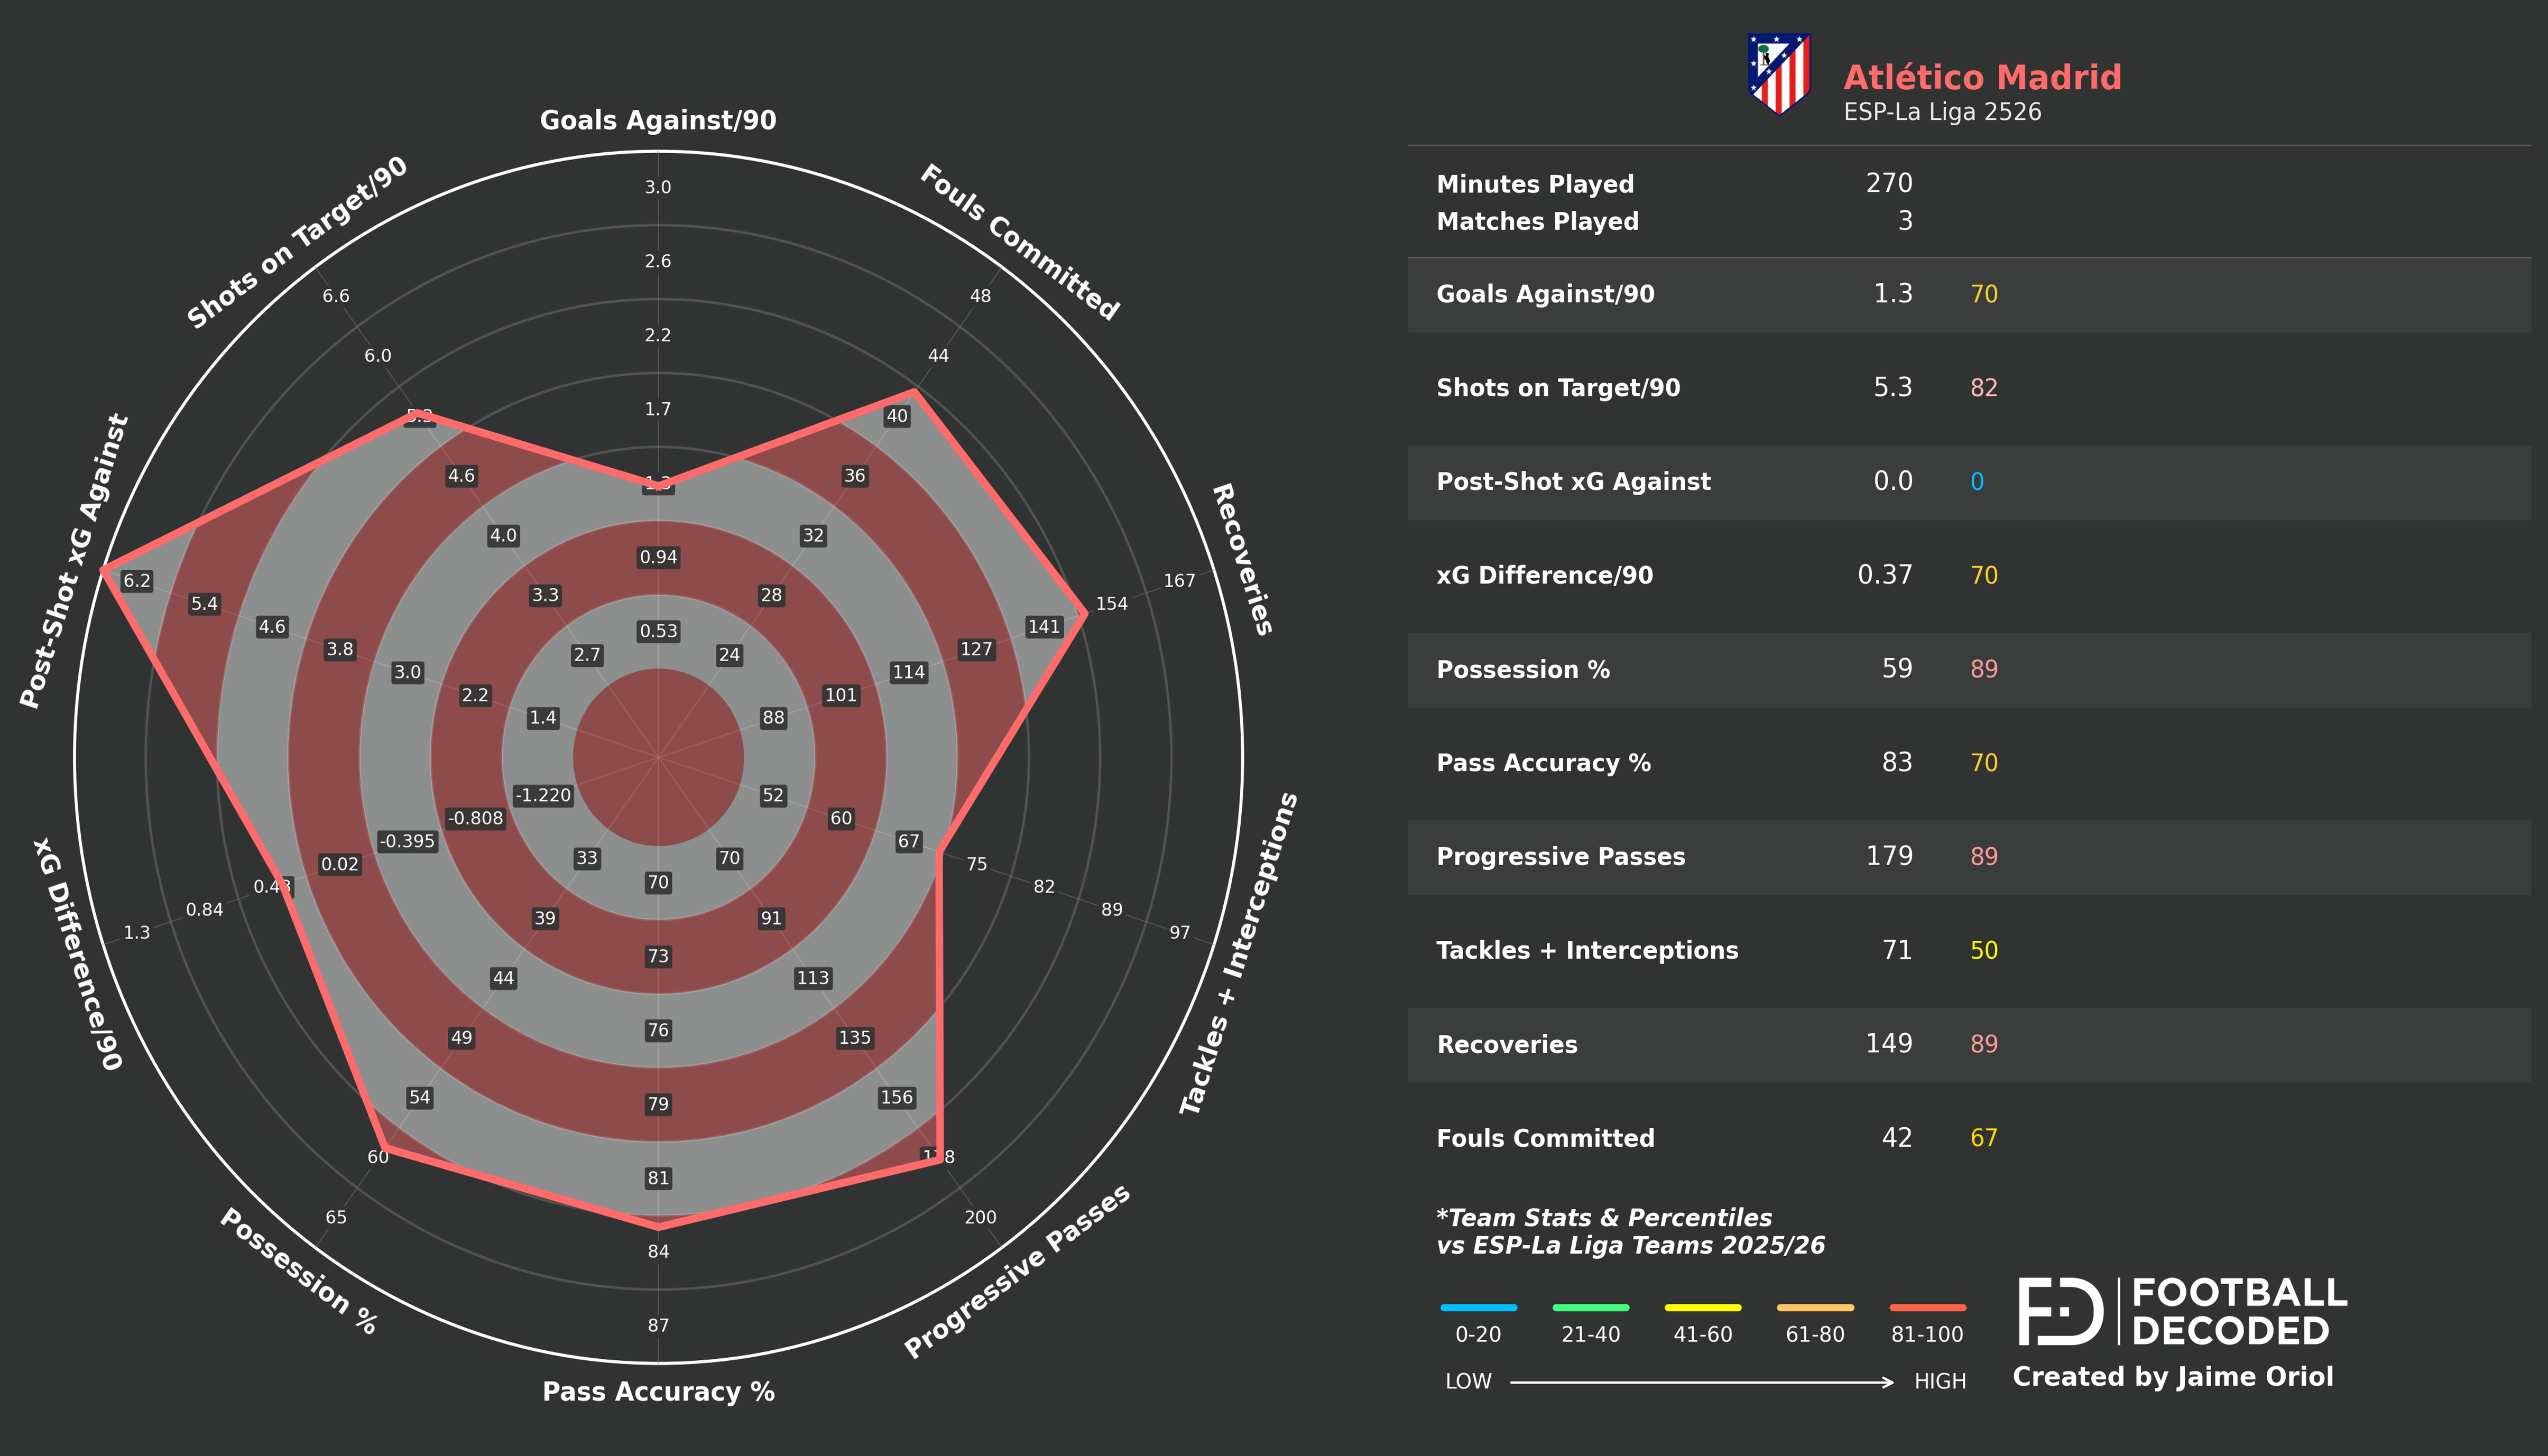

In [9]:
# Generar el radar del equipo
if len(atletico_data) > 0:
    from viz.swarm_radar import create_player_radar
    from viz.stats_radar import create_stats_table, combine_radar_and_table
    from IPython.display import Image as IPImage, display
    
    # Usar métricas disponibles
    final_metrics = [m for m in team_radar_metrics if m in available_metrics]
    final_titles = [t for m, t in zip(team_radar_metrics, team_radar_titles) if m in available_metrics]
    
    print(f"Generando radar del {TARGET_TEAM} con {len(final_metrics)} métricas...")
    
    try:
        # Crear radar del equipo
        create_player_radar(
            df_data=df_teams_final,
            player_1_id=atletico_id,
            metrics=final_metrics,
            metric_titles=final_titles,
            team_colors=ATM_COLORS,
            save_path=f"{SAVE_PATH_BASE}Atletico_Madrid_team_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Crear tabla de estadísticas
        create_stats_table(
            df_data=df_teams_final,
            player_1_id=atletico_id,
            metrics=final_metrics,
            metric_titles=final_titles,
            team_colors=ATM_COLORS,
            save_path=f"{SAVE_PATH_BASE}Atletico_Madrid_team_table.png",
            team_logos={TARGET_TEAM: '../logos/LaLiga/Atleti.png'},
            footer_text=f"Team Stats & Percentiles\nvs ESP-La Liga Teams 2025/26",
            show_plot=False
        )
        
        # Combinar radar y tabla
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}Atletico_Madrid_team_radar.png",
            table_path=f"{SAVE_PATH_BASE}Atletico_Madrid_team_table.png",
            output_path=f"{SAVE_PATH_BASE}Atletico_Madrid_team_combined.png"
        )
        
        print(f"✓ Radar del equipo completado: Atletico_Madrid_team_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}Atletico_Madrid_team_combined.png"))
        
    except Exception as e:
        print(f"✗ Error generando radar del equipo: {str(e)}")
        
else:
    print("No se puede generar el radar sin datos del Atlético Madrid")